Improving on the All-Weather Portfolio:

This Machine Learning Exercise will take the recommended All Weather Portfolio generated in the EDA and Inferential Statistics portion of the Capstone and seek to mitigate losses from the stock market by shifting funds to another part of the portfolio ahead of a downturn.

To do this, the VIGRX stock index fund will be evaluated from its inception, and moving averages will be computed as features in a dataframe.  Machine Learning algorithms will then be tested against the moving averages to determine if one or more of these averages are predictive of a significant loss within the next month.  A distribution of losses will be determined and significant losses will be identified as the top 10% of losses experienced by the fund.

Additionally, moving averages across the whole portfolio will be treated in a similar fashion and a trained under similar conditions.

The machine learning algorithms employed will then be tested on the data from May 2018 to Dec 2018 to see which can most accurately predict the weeks of heavy losses in VIGRX price within that period.


In [1]:
# Import essential libraries #

import pandas as pd
import numpy as np
from numpy import percentile
import math
import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import reduce
import warnings
from random import randint
import seaborn as sns
import imblearn
%matplotlib inline

warnings.filterwarnings(action='once')

# Preprocessing Test Fund and Fund Categories for ML

In [2]:
processed = pd.read_csv('csv_files/historical_record.csv')
processed.index = pd.to_datetime(processed.index)
processed = processed.iloc[35:, :]

processed.head()

processed.reset_index()
processed.index = processed['Date']
processed = processed.drop('Date', axis = 1)

processed = processed[['VIGRX', 'Stocks 2_Week_Avg', 'Stocks 3_Week_Avg',
       'Stocks 6_Week_Avg', 'Stocks 9_Week_Avg', 'Stocks 12_Week_Avg',
       'Stocks 15_Week_Avg',  'ITB 2_Week_Avg',
       'ITB 3_Week_Avg', 'ITB 6_Week_Avg', 'ITB 9_Week_Avg', 'ITB 12_Week_Avg',
       'ITB 15_Week_Avg', 'LTB 2_Week_Avg', 'LTB 3_Week_Avg',
       'LTB 6_Week_Avg', 'LTB 9_Week_Avg', 'LTB 12_Week_Avg',
       'LTB 15_Week_Avg',  'Gold 2_Week_Avg',
       'Gold 3_Week_Avg', 'Gold 6_Week_Avg', 'Gold 9_Week_Avg',
       'Gold 12_Week_Avg', 'Gold 15_Week_Avg', 
       'Commod 2_Week_Avg', 'Commod 3_Week_Avg', 'Commod 6_Week_Avg',
       'Commod 9_Week_Avg', 'Commod 12_Week_Avg', 'Commod 15_Week_Avg',
        'VIGRX 2_Week_Avg', 'VIGRX 3_Week_Avg', 'VIGRX 6_Week_Avg',
       'VIGRX 9_Week_Avg', 'VIGRX 12_Week_Avg', 'VIGRX 15_Week_Avg']]

full_features = processed

In [3]:
full_features.head()

,VIGRX,Stocks 2_Week_Avg,Stocks 3_Week_Avg,Stocks 6_Week_Avg,Stocks 9_Week_Avg,Stocks 12_Week_Avg,Stocks 15_Week_Avg,ITB 2_Week_Avg,ITB 3_Week_Avg,ITB 6_Week_Avg,...,Commod 6_Week_Avg,Commod 9_Week_Avg,Commod 12_Week_Avg,Commod 15_Week_Avg,VIGRX 2_Week_Avg,VIGRX 3_Week_Avg,VIGRX 6_Week_Avg,VIGRX 9_Week_Avg,VIGRX 12_Week_Avg,VIGRX 15_Week_Avg
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-26,0.996980,1.031336,1.038539,1.038476,1.002234,0.995471,1.025399,1.000795,1.002782,0.998095,...,1.070515,1.087540,1.065290,1.075500,1.030502,1.047411,1.049665,1.008135,1.009026,1.043334
2018-05-19,1.009894,1.029670,1.034997,1.028289,0.975155,1.010232,0.954383,1.001561,1.004408,0.998555,...,1.064611,1.068667,1.073802,1.046887,1.037149,1.052820,1.038660,0.977703,1.023792,0.972357
2018-05-12,1.020405,1.012194,0.998847,0.993990,0.973234,1.008409,0.938176,1.004834,0.997317,0.998114,...,1.039690,1.039324,1.083971,1.043449,1.031766,1.010601,1.003668,0.983836,1.029545,0.953157
2018-05-05,1.016409,0.991919,0.999938,0.965042,0.958530,0.987347,0.950751,0.995340,0.995326,0.997898,...,1.044711,1.023338,1.033146,1.033903,0.994285,1.002152,0.962502,0.963352,0.996108,0.959710
2018-04-28,1.015110,0.994792,0.993518,0.942181,0.976073,0.922112,0.954585,0.992505,0.994172,0.994214,...,1.031892,1.036850,1.010861,1.030569,0.987235,0.986550,0.928652,0.972428,0.923574,0.952096


In [4]:
# Identify the training data and targets

training_df = full_features
observations = training_df.iloc[:, 1:37]
obs = observations.transpose()

X = []

for i in range(obs.shape[1]):
    x = obs.iloc[:,i].values
    X.append(x)

dependent = training_df.iloc[:, 0].values

y = dependent

delta = 0.02

below_98 = round(len(y[np.where(dependent <= 1 - delta)])/len(dependent)*100, 4)
below_98

above_102 = round(len(y[np.where(dependent >= 1 + delta)])/len(dependent)*100, 4)
above_102

print('The proportion of observations below 98% is: ', below_98,', and the number above 102%: ', above_102)


#Resolve the target column as binary
for i in range(len(y)):
    if y[i] <= 0.98:
        y[i] = 0
    if y[i] > 0.98:
        y[i] = 1
        
dependent

data = observations

data['target'] = dependent

# Resample to handle imbalances in distribution of 

# Class Count

count_class_0, count_class_1 = data.target.value_counts()

df_class_0 = data[data['target'] == 0]
df_class_1 = data[data['target'] == 1]



The proportion of observations below 98% is:  13.2635 , and the number above 102%:  15.7068


Random under-sampling:
1.0    497
0.0     76
Name: target, dtype: int64


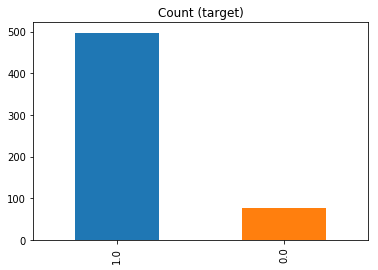

In [5]:
# Examine present sampling of each class.

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

Now that a training dataframe has been developed and a holdout set has been identified.  We will try various classifier methods to identify when the stock index is at a risk of a significant loss (2% or more).  Because such losses constitute 13% of the weeks in the training set (a fairly small amount), we will also perform some resampling of the data using the imbalanced-learn module to arrive at a more useful predictor.



# Resampling using Imbalanced-Learn


In [6]:
# Using Naive Oversampling and imblearn's Random Oversampler, create a resampled dataset on which to train

from sklearn.datasets import make_classification
X, y = make_classification(n_samples=800, n_features=36, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.30, 0.70],
                           class_sep=0.8, random_state=0)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

len(X_resampled), len(y_resampled)

/Users/nina/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


(1112, 1112)

# Support Vector Machine

In [7]:
# SVM Training
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

k = 0.98
    
svc = SVC()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 10)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
    
print('for tolerance value k = ', k)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


for tolerance value k =  0.98
[[168  16]
 [ 10 140]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       184
           1       0.90      0.93      0.92       150

   micro avg       0.92      0.92      0.92       334
   macro avg       0.92      0.92      0.92       334
weighted avg       0.92      0.92      0.92       334



/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [8]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    gammas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

print('for tolerance k = ', k)
print(svc_param_selection(X_resampled, y_resampled, 5))

for tolerance k =  0.98
{'C': 10, 'gamma': 0.1}


/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [9]:
for k in [0.98]:

    svc = SVC(C = 10, gamma = 0.1)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 10)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    
    print('for tolerance value k = ', k)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


for tolerance value k =  0.98
[[136  48]
 [  1 149]]
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       184
           1       0.76      0.99      0.86       150

   micro avg       0.85      0.85      0.85       334
   macro avg       0.87      0.87      0.85       334
weighted avg       0.89      0.85      0.85       334



# Logistic Regression 

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

for k in [0.98]:
    # Setup the hyperparameter grid
    c_space = np.logspace(-5, 8, 15)
    param_grid = {'C': c_space}

    # Instantiate a logistic regression classifier: logreg
    logreg = LogisticRegression()

    # Instantiate the GridSearchCV object: logreg_cv
    logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

    # Fit it to the data
    logreg_cv.fit(X_resampled, y_resampled)

    #Print the tuned parameters and score
    print('For tolerance value k = ', k)
    print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
    print("Best score is {}".format(logreg_cv.best_score_))


/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 

For tolerance value k =  0.98
Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}
Best score is 0.8830935251798561


/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

for k in [0.98]:

    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state=10)

    # Create the classifier: logreg
    logreg = LogisticRegression(C = 0.4393970560760795)

    # Fit the classifier to the training data
    logreg.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = logreg.predict(X_test)

    # Compute and print the confusion matrix and classification report
    print(confusion_matrix(y_test, y_pred))
    print('For k tolerance ', k)
    print(classification_report(y_test, y_pred))
    


[[164  20]
 [ 12 138]]
For k tolerance  0.98
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       184
           1       0.87      0.92      0.90       150

   micro avg       0.90      0.90      0.90       334
   macro avg       0.90      0.91      0.90       334
weighted avg       0.91      0.90      0.90       334



/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression had an f1 split of .91/.90 and is comparable to untuned SVC.


# Gradient Boosting

In [14]:
from sklearn.ensemble import GradientBoostingClassifier


for k in [0.98]:
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state=10)

    # Create the classifier: logreg
    gbc = GradientBoostingClassifier()

    # Fit the classifier to the training data
    gbc.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = gbc.predict(X_test)

    #Compute and print the confusion matrix and classification report
    print(confusion_matrix(y_test, y_pred))
    print('For k tolerance ', k)
    print(classification_report(y_test, y_pred))


[[176   8]
 [ 14 136]]
For k tolerance  0.98
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       184
           1       0.94      0.91      0.93       150

   micro avg       0.93      0.93      0.93       334
   macro avg       0.94      0.93      0.93       334
weighted avg       0.93      0.93      0.93       334



In [15]:
from sklearn.model_selection import cross_val_score

# Function modified to accept resampled training and test data instead of a pandas dataframe

def modelfit(alg, dtrain, predictors, target, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [16]:
# Since the model fit function for GB tuning only accepts a dataframe as its input, we need to rebuild a dataframe
# for the resampled values of X and y.

dtrain = pd.DataFrame(X_resampled)
    
dtrain.columns = ['Stocks 2_Week_Avg', 'Stocks 3_Week_Avg',
       'Stocks 6_Week_Avg', 'Stocks 9_Week_Avg', 'Stocks 12_Week_Avg',
       'Stocks 15_Week_Avg',  'ITB 2_Week_Avg',
       'ITB 3_Week_Avg', 'ITB 6_Week_Avg', 'ITB 9_Week_Avg', 'ITB 12_Week_Avg',
       'ITB 15_Week_Avg', 'LTB 2_Week_Avg', 'LTB 3_Week_Avg',
       'LTB 6_Week_Avg', 'LTB 9_Week_Avg', 'LTB 12_Week_Avg',
       'LTB 15_Week_Avg',  'Gold 2_Week_Avg',
       'Gold 3_Week_Avg', 'Gold 6_Week_Avg', 'Gold 9_Week_Avg',
       'Gold 12_Week_Avg', 'Gold 15_Week_Avg', 
       'Commod 2_Week_Avg', 'Commod 3_Week_Avg', 'Commod 6_Week_Avg',
       'Commod 9_Week_Avg', 'Commod 12_Week_Avg', 'Commod 15_Week_Avg',
        'VIGRX 2_Week_Avg', 'VIGRX 3_Week_Avg', 'VIGRX 6_Week_Avg',
       'VIGRX 9_Week_Avg', 'VIGRX 12_Week_Avg', 'VIGRX 15_Week_Avg']

dtrain['target'] = y_resampled
dtrain.shape

(1112, 37)

In [17]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import metrics   #Additional scklearn functions

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.999521
CV Score : Mean - 0.9748073 | Std - 0.007357664 | Min - 0.9685906 | Max - 0.9864459


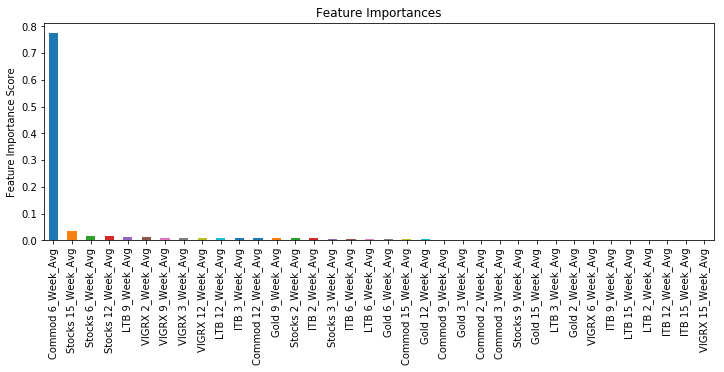

In [18]:
# Select Predictors, Target & IDcols to comply with existing tuning code.  Then fit the first model

train = dtrain

target = 'target'
IDcol = dtrain.index

predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=38)
modelfit(gbm0, train, predictors, target)



In [19]:
#Set baselines for parameters and begin experimenting with the number of trees and learning rate.

predictors = [x for x in train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':np.arange(20, 60, 5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, 
                                                               min_samples_split=130,
                                                               min_samples_leaf=10,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10),
                                                               param_grid = param_test1, 
                                                               scoring='roc_auc', 
                                                               n_jobs=4,
                                                               iid=False, 
                                                               cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_   
   

/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.

({'mean_fit_time': array([0.08727427, 0.11415195, 0.13989367, 0.14163537, 0.140485  ,
         0.15251312, 0.18722267, 0.17684836]),
  'std_fit_time': array([0.01447917, 0.01152219, 0.00403871, 0.01431125, 0.00309961,
         0.00638258, 0.01724402, 0.02611587]),
  'mean_score_time': array([0.00551939, 0.00856719, 0.00478454, 0.0039278 , 0.00391278,
         0.0041954 , 0.00644875, 0.00347061]),
  'std_score_time': array([0.0008521 , 0.003666  , 0.00166662, 0.00015477, 0.00012447,
         0.00018592, 0.00292489, 0.00061802]),
  'param_n_estimators': masked_array(data=[20, 25, 30, 35, 40, 45, 50, 55],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 25},
   {'n_estimators': 30},
   {'n_estimators': 35},
   {'n_estimators': 40},
   {'n_estimators': 45},
   {'n_estimators': 50},
   {'n_estimators': 55}],
  'split0_test_score': array([0.94212372, 0.945

In [20]:
# Tune tree characteristics:  max_depth, and min_samples_split

param_test2 = {'max_depth':np.arange(3,12,1), 'min_samples_split':np.arange(100,300,10)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=55,random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_


/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.

({'mean_fit_time': array([0.64567719, 0.51512208, 0.39644971, 0.46032596, 0.37092152,
         0.37258019, 0.37969079, 0.4021111 , 0.47704053, 0.48702388,
         0.37554784, 0.40559549, 0.42703195, 0.3643198 , 0.36608357,
         0.35408587, 0.35331559, 0.35252857, 0.3287056 , 0.35018225,
         0.63604813, 0.66474881, 0.57007742, 0.51835237, 0.50214901,
         0.48510733, 0.4617806 , 0.4557137 , 0.44353738, 0.43571892,
         0.44604635, 0.45259519, 0.43817024, 0.48744979, 0.44905343,
         0.43903971, 0.45549736, 0.46321888, 0.62166491, 0.4683507 ,
         0.73051147, 0.6209136 , 0.60274692, 0.59451404, 0.59798064,
         0.55623932, 0.54225965, 0.57436299, 0.71142654, 0.66453552,
         0.54615145, 0.51155457, 0.49398613, 0.48970814, 0.51437998,
         0.48023615, 0.55205717, 0.57781734, 0.45422263, 0.43318167,
         0.66865954, 0.66113873, 0.67684817, 0.64347224, 0.64242096,
         0.64209981, 0.62079144, 0.60150332, 0.58084416, 0.5797358 ,
         0.575071

In [21]:
# Tune min_samples_split along with min_samples_leaf

param_test3 = {'min_samples_split':np.arange(100,400,10), 'min_samples_leaf':np.arange(5,100,5)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=55, max_depth=11, min_samples_split = 100, max_features='sqrt',random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_



/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.

({'mean_fit_time': array([0.30998673, 0.27757998, 0.26821885, 0.24448681, 0.2210547 ,
         0.20268149, 0.20209365, 0.22734866, 0.25516992, 0.220854  ,
         0.19761524, 0.23221779, 0.1798142 , 0.18490019, 0.16508579,
         0.16970139, 0.15256462, 0.16654077, 0.26970015, 0.3868773 ,
         0.28405156, 0.19631495, 0.22571507, 0.26083183, 0.19533415,
         0.20842738, 0.22073064, 0.23302546, 0.2693171 , 0.23718324,
         0.38978114, 0.47244873, 0.53935399, 0.43977652, 0.38928809,
         0.38318858, 0.32187696, 0.34944649, 0.25751228, 0.24489355,
         0.2759316 , 0.2085916 , 0.192664  , 0.19139132, 0.18067083,
         0.17794123, 0.17311378, 0.15819559, 0.16908503, 0.19921308,
         0.1943397 , 0.23518519, 0.17082319, 0.26473227, 0.26236615,
         0.24966006, 0.26123276, 0.19690003, 0.17599621, 0.15778313,
         0.3184186 , 0.26337032, 0.26824021, 0.23254147, 0.22672906,
         0.22437735, 0.19556756, 0.18756886, 0.19140253, 0.19224949,
         0.173950


Model Report
Accuracy : 0.9811
AUC Score (Train): 0.998871
CV Score : Mean - 0.9779744 | Std - 0.006678211 | Min - 0.9715932 | Max - 0.9877445


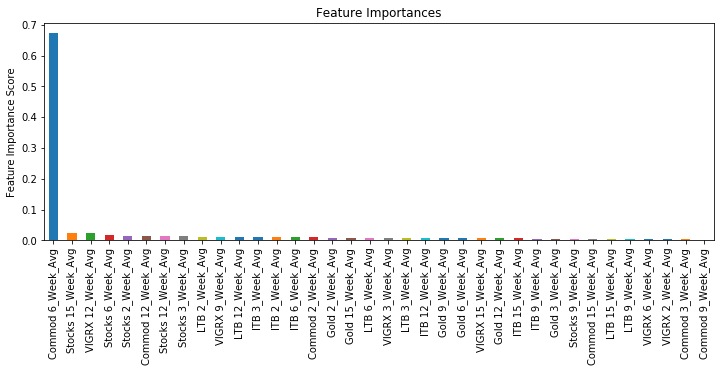

In [22]:
# Observe impact using modelfit function

modelfit(gsearch3.best_estimator_, train, predictors, target)

In [23]:
# Tune max_features

param_test4 = {'max_features':np.arange(3,20,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, 
                                                               n_estimators=55,
                                                               max_depth=11, 
                                                               min_samples_split =110,
                                                               min_samples_leaf =10, 
                                                               random_state=10 
                                                               ),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_


/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.

({'mean_fit_time': array([0.24120126, 0.23771334, 0.32531738, 0.26484699, 0.30065699,
         0.2819253 , 0.2766202 , 0.28506436, 0.30002127, 0.31503806,
         0.33296905, 0.36689992, 0.36803026, 0.38937559, 0.46382141,
         0.58328285, 0.55117478]),
  'std_fit_time': array([0.02909376, 0.04749398, 0.0144569 , 0.02946482, 0.03674921,
         0.0269223 , 0.01125566, 0.01051773, 0.01196954, 0.01257851,
         0.01045386, 0.02407344, 0.00980508, 0.01136059, 0.08194966,
         0.03801853, 0.06817143]),
  'mean_score_time': array([0.01211395, 0.00441642, 0.00621963, 0.00435266, 0.00869436,
         0.00428214, 0.00628691, 0.00409207, 0.00392551, 0.00407848,
         0.00406013, 0.0041585 , 0.00396156, 0.00403585, 0.0061306 ,
         0.00581779, 0.00820398]),
  'std_score_time': array([5.32364728e-03, 6.46101688e-04, 1.80709178e-03, 2.28722765e-04,
         4.79638722e-03, 6.86023990e-04, 2.05216334e-03, 2.25339115e-04,
         8.51725672e-05, 1.98089003e-04, 8.40794672e-05, 4

In [25]:
# Tune Subsample

param_test5 = {'subsample':[0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, 
                                                               n_estimators=55,
                                                               max_depth=11,
                                                               min_samples_split=110, 
                                                               min_samples_leaf=10, 
                                                               max_features=6,
                                                               random_state=10),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_


/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nina/anaconda3/lib/python3.

({'mean_fit_time': array([0.1088912 , 0.11211677, 0.12194719, 0.16782908, 0.22920847,
         0.23840141, 0.286165  , 0.23200493, 0.27492719, 0.18700395]),
  'std_fit_time': array([0.01462861, 0.01050082, 0.00694085, 0.03132884, 0.0258527 ,
         0.0337829 , 0.04682278, 0.01770792, 0.02673542, 0.05067578]),
  'mean_score_time': array([0.00478811, 0.00393281, 0.00399704, 0.00506372, 0.00613823,
         0.00476885, 0.0071353 , 0.00567255, 0.00634398, 0.00314803]),
  'std_score_time': array([1.95003402e-03, 1.08106209e-04, 7.46516555e-05, 1.53486970e-03,
         1.99408249e-03, 1.32701610e-03, 4.81505766e-03, 1.42523491e-03,
         1.86142544e-03, 7.75524946e-04]),
  'param_subsample': masked_array(data=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.2},
   {'subsample': 0.3},
   {'


Model Report
Accuracy : 0.9811
AUC Score (Train): 0.998871
CV Score : Mean - 0.9779744 | Std - 0.006678211 | Min - 0.9715932 | Max - 0.9877445


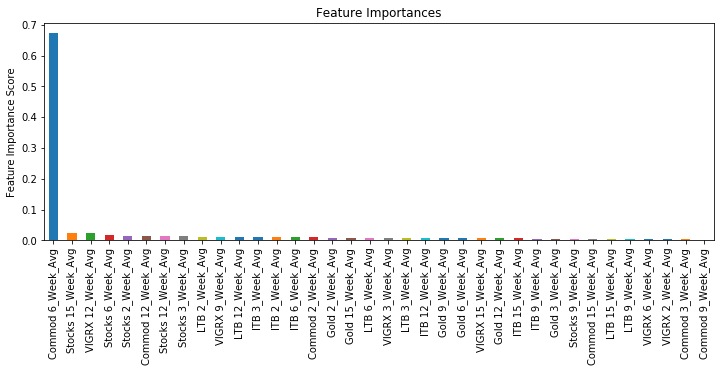

In [26]:
# Run a new ModelFit with tuned hyperparameters

predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=55,
                                         max_depth=11, min_samples_split=110,
                                         min_samples_leaf=10, 
                                         random_state = 10, max_features=6)
modelfit(gbm_tuned_1, train, predictors, target)


Model Report
Accuracy : 0.9101
AUC Score (Train): 0.974610
CV Score : Mean - 0.9531271 | Std - 0.007273504 | Min - 0.9443227 | Max - 0.9642886


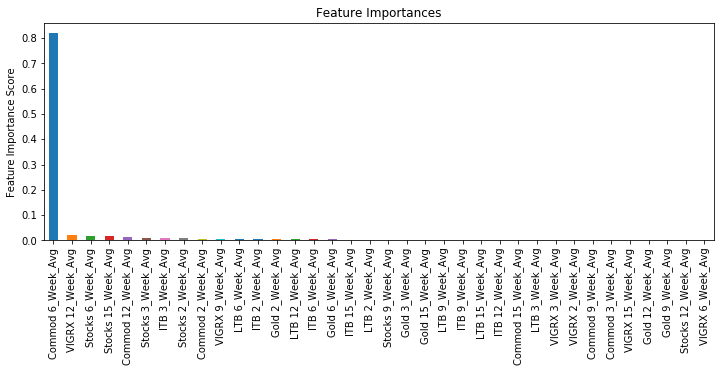

In [27]:
# Proportionally lower the learning rate and raise the number of trees

predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=275,
                                         max_depth=3, min_samples_split=350,
                                         min_samples_leaf=95, 
                                         random_state=10, max_features=5)
modelfit(gbm_tuned_2, train, predictors, target)

In [28]:
# Test GBM against the critical data from stock market.

for k in [0.98]:

    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.4, random_state=10)

    # Create the classifier: gbc
    gbc = gbm_tuned_1

    # Fit the classifier to the training data
    gbc.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = gbc.predict(X_test)

    #Compute and print the confusion matrix and classification report
    print(confusion_matrix(y_test, y_pred))
    print('For k tolerance ', k)
    print(classification_report(y_test, y_pred))



[[212  25]
 [ 13 195]]
For k tolerance  0.98
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       237
           1       0.89      0.94      0.91       208

   micro avg       0.91      0.91      0.91       445
   macro avg       0.91      0.92      0.91       445
weighted avg       0.92      0.91      0.91       445



Gradient Boosting Summary:

The untuned model outperformed the tuned model with an F1 split of .94/.93.  This is now the front runner for accuracy.





# Decision Tree

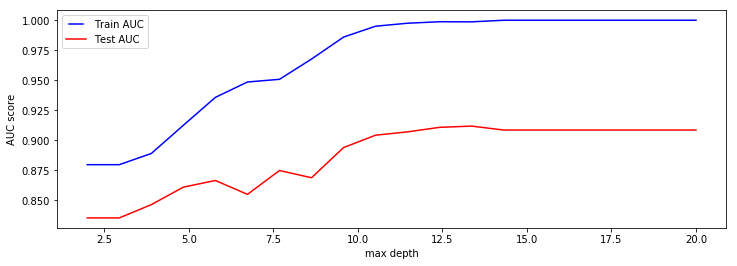

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc


for k in [0.98]:
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 38)
    
    max_depths = np.linspace(2, 20, 20, endpoint=True)
    train_results = []
    test_results = []

    for max_depth in max_depths:
        dtc = DecisionTreeClassifier(max_depth=max_depth, random_state = 10)
        dtc.fit(X_train, y_train)
        train_pred = dtc.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous train results
        train_results.append(roc_auc)
        y_pred = dtc.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous test results
        test_results.append(roc_auc)

    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, color = 'b', label="Train AUC")
    line2, = plt.plot(max_depths, test_results, color = 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('max depth')
    plt.show()




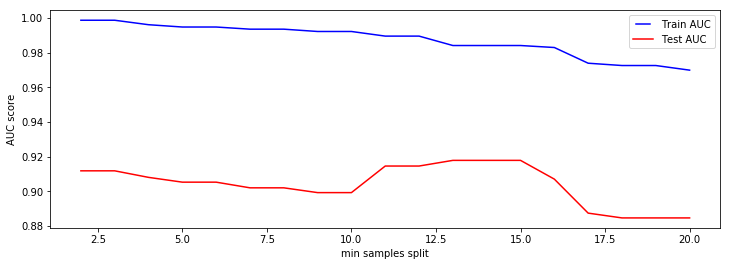

In [30]:
# This cell runs the Decision Tree Classifier and tunes the min sample splits parameter
for k in[0.98]:

    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 38)
    
    min_samples_splits = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    train_results = []
    test_results = []
    for min_samples_split in min_samples_splits:
        dtc = DecisionTreeClassifier(max_depth = 13, min_samples_split=min_samples_split, random_state = 10)
        dtc.fit(X_train, y_train)
        train_pred = dtc.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = dtc.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min samples split')
    plt.show()


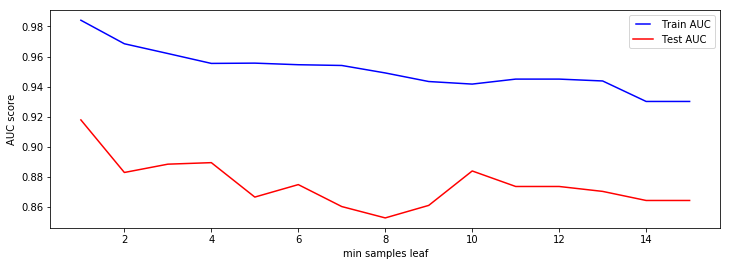

In [31]:
for k in [0.98]:
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 38)
    
    min_samples_leafs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    train_results = []
    test_results = []
    for min_samples_leaf in min_samples_leafs:
        dtc = DecisionTreeClassifier(max_depth = 13, min_samples_split = 15, min_samples_leaf=min_samples_leaf, random_state = 10)
        dtc.fit(X_train, y_train)
        train_pred = dtc.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = dtc.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min samples leaf')
    plt.show()
                      

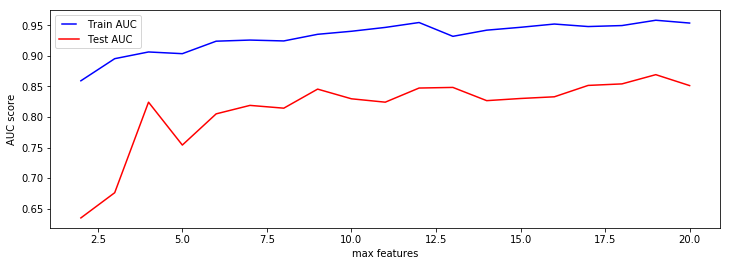

In [33]:
for k in [0.98]:
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 38)
    
    max_features = [2, 3, 4, 5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    train_results = []
    test_results = []
    for max_feature in max_features:
        dtc = DecisionTreeClassifier(max_depth = 13, min_samples_split = 15, min_samples_leaf = 4, max_features = max_feature, random_state = 10)
        dtc.fit(X_train, y_train)
        train_pred = dtc.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = dtc.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('max features')
    plt.show()

In [35]:
# Tuned Decision Tree:

for k in [0.98]:

    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 38)
    
    dtc = DecisionTreeClassifier(max_depth = 13, min_samples_split = 15, min_samples_leaf=4, max_features = 19, random_state = 10)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)

    #Compute and print the confusion matrix and classification report
    print(confusion_matrix(y_test, y_pred))
    print('For k tolerance ', k)
    print(classification_report(y_test, y_pred))


[[140  13]
 [ 32 149]]
For k tolerance  0.98
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       153
           1       0.92      0.82      0.87       181

   micro avg       0.87      0.87      0.87       334
   macro avg       0.87      0.87      0.87       334
weighted avg       0.87      0.87      0.87       334



# Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

for k in [0.98]:

    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 38)

    # Create the classifier: logreg
    rfc = RandomForestClassifier(random_state = 10)

    # Fit the classifier to the training data
    rfc.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = rfc.predict(X_test)

    #Compute and print the confusion matrix and classification report
#    print(confusion_matrix(y_test, y_pred))
    print('For k tolerance ', k)
    print(classification_report(y_test, y_pred))


For k tolerance  0.98
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       153
           1       0.95      0.86      0.90       181

   micro avg       0.90      0.90      0.90       334
   macro avg       0.90      0.90      0.90       334
weighted avg       0.90      0.90      0.90       334



/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


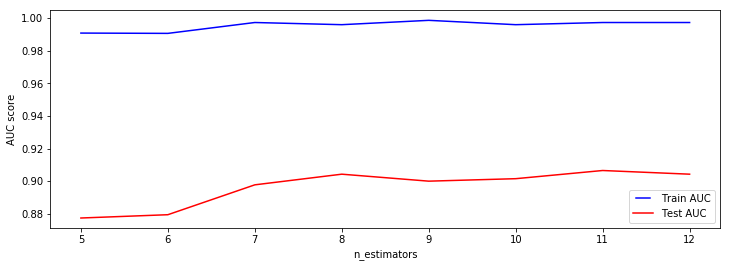

In [41]:
n_estimators = [5, 6, 7, 8, 9, 10, 11, 12]
train_results = []
test_results = []

for k in [0.98]:

    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 38)

for estimator in n_estimators:
    rfc = RandomForestClassifier(n_estimators=estimator, n_jobs=-1, random_state=10)
    rfc.fit(X_train, y_train)
    train_pred = rfc.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rfc.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

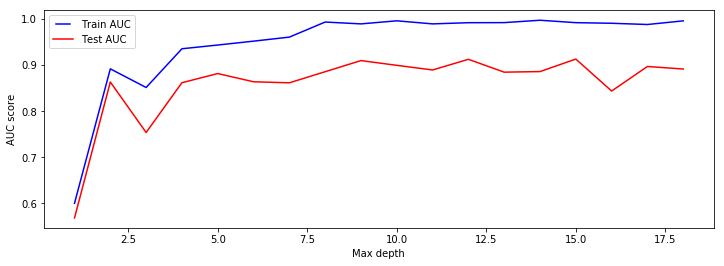

In [42]:

max_depths = np.linspace(1, 18, 18, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rfc = RandomForestClassifier(n_estimators = 8, max_depth=max_depth, n_jobs=-1)
    rfc.fit(X_train, y_train)
    train_pred = rfc.predict(X_train) 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rfc.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Max depth')
plt.show()

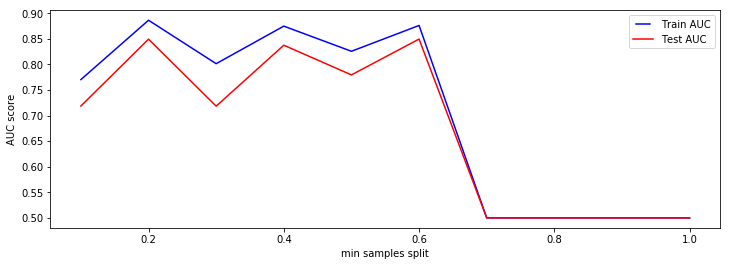

In [43]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rfc = RandomForestClassifier(n_estimators = 8, max_depth = 2, min_samples_split=min_samples_split)
    rfc.fit(X_train, y_train)
    train_pred = rfc.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rfc.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

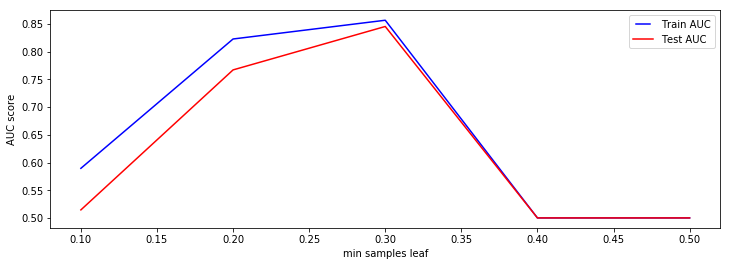

In [44]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rfc = RandomForestClassifier(n_estimators = 8, max_depth = 2, min_samples_leaf=min_samples_leaf, min_samples_split = 0.6)
    rfc.fit(X_train, y_train)
    train_pred = rfc.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rfc.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

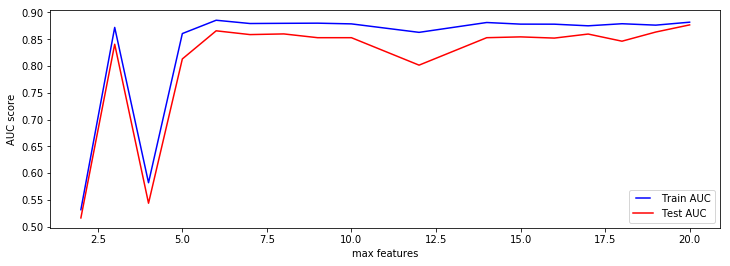

In [45]:
max_features = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20]
train_results = []
test_results = []
for max_feature in max_features:
    rfc = RandomForestClassifier(n_estimators = 8, max_depth = 2, min_samples_leaf = 0.3, min_samples_split = 0.6, max_features=max_feature)
    rfc.fit(X_train, y_train)
    train_pred = rfc.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rfc.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

In [48]:
# Tuned Random Forest

for k in [0.98]:

    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state=38)

    # Create the classifier: logreg
    rfc = RandomForestClassifier(n_estimators = 8, max_depth = 2, min_samples_leaf = 0.3, 
                                 min_samples_split = 0.6, max_features=6)

    # Fit the classifier to the training data
    rfc.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = rfc.predict(X_test)

    #Compute and print the confusion matrix and classification report
    print(confusion_matrix(y_test, y_pred))
    #print('For k tolerance ', k)
    print(classification_report(y_test, y_pred))
    



[[126  27]
 [ 37 144]]
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       153
           1       0.84      0.80      0.82       181

   micro avg       0.81      0.81      0.81       334
   macro avg       0.81      0.81      0.81       334
weighted avg       0.81      0.81      0.81       334



# The Lightning Round!

Here, the best performing versions of each algorithm will be given data from June 1st, 2018 to Feb 1st, 2019.  Here, we will see which algorithm best predicts the market downturns that began in October 2018.  

In [49]:
for_testing = pd.read_csv('csv_files/historical_record.csv')
for_testing.index = pd.to_datetime(for_testing.index)
for_testing = for_testing.iloc[0:34, :]

for_testing.reset_index()
for_testing.index = for_testing['Date']
for_testing = for_testing.drop('Date', axis = 1)

for_testing = for_testing[['VIGRX', 'Stocks 2_Week_Avg', 'Stocks 3_Week_Avg',
       'Stocks 6_Week_Avg', 'Stocks 9_Week_Avg', 'Stocks 12_Week_Avg',
       'Stocks 15_Week_Avg',  'ITB 2_Week_Avg',
       'ITB 3_Week_Avg', 'ITB 6_Week_Avg', 'ITB 9_Week_Avg', 'ITB 12_Week_Avg',
       'ITB 15_Week_Avg', 'LTB 2_Week_Avg', 'LTB 3_Week_Avg',
       'LTB 6_Week_Avg', 'LTB 9_Week_Avg', 'LTB 12_Week_Avg',
       'LTB 15_Week_Avg',  'Gold 2_Week_Avg',
       'Gold 3_Week_Avg', 'Gold 6_Week_Avg', 'Gold 9_Week_Avg',
       'Gold 12_Week_Avg', 'Gold 15_Week_Avg', 
       'Commod 2_Week_Avg', 'Commod 3_Week_Avg', 'Commod 6_Week_Avg',
       'Commod 9_Week_Avg', 'Commod 12_Week_Avg', 'Commod 15_Week_Avg',
        'VIGRX 2_Week_Avg', 'VIGRX 3_Week_Avg', 'VIGRX 6_Week_Avg',
       'VIGRX 9_Week_Avg', 'VIGRX 12_Week_Avg', 'VIGRX 15_Week_Avg']]

test_features = for_testing

test_obs = test_features.iloc[:, 1:37]
t_obs = test_obs.transpose()

X_testing = []

for i in range(t_obs.shape[1]):
    x_testing = t_obs.iloc[:,i].values
    X_testing.append(x_testing)

outcomes = test_features.iloc[:, 0].values

y_testing = outcomes

delta = 0.02

below_98 = round(len(outcomes[np.where(outcomes <= 1 - delta)])/len(outcomes)*100, 4)

above_102 = round(len(outcomes[np.where(outcomes >= 1 + delta)])/len(outcomes)*100, 4)

print('The proportion of observations below 98% is: ', below_98,', and the number above 102%: ', above_102)


#Resolve the target column as binary
for i in range(len(y_testing)):
    if y_testing[i] <= 0.98:
        y_testing[i] = 0
    if y_testing[i] > 0.98:
        y_testing[i] = 1
        


The proportion of observations below 98% is:  26.4706 , and the number above 102%:  8.8235


In [52]:
svc = SVC()

svc.fit(X_resampled, y_resampled)

y_predict = svc.predict(X_testing)
    
print('for tolerance value k = ', k)
print(confusion_matrix(y_testing, y_predict))
print(classification_report(y_testing, y_predict))

for tolerance value k =  0.98
[[ 0  9]
 [ 0 25]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.74      1.00      0.85        25

   micro avg       0.74      0.74      0.74        34
   macro avg       0.37      0.50      0.42        34
weighted avg       0.54      0.74      0.62        34



/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
svc = SVC(C = 10, gamma = 0.1)

svc.fit(X_resampled, y_resampled)

y_predict = svc.predict(X_testing)
    
print('for tolerance value k = ', k)
print(confusion_matrix(y_testing, y_predict))
print(classification_report(y_testing, y_predict))

for tolerance value k =  0.98
[[ 0  9]
 [ 0 25]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.74      1.00      0.85        25

   micro avg       0.74      0.74      0.74        34
   macro avg       0.37      0.50      0.42        34
weighted avg       0.54      0.74      0.62        34



/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
logreg = LogisticRegression()

logreg.fit(X_resampled, y_resampled)

y_predict = logreg.predict(X_testing)
    
print('for tolerance value k = ', k)
print(confusion_matrix(y_testing, y_predict))
print(classification_report(y_testing, y_predict))

for tolerance value k =  0.98
[[ 0  9]
 [ 0 25]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.74      1.00      0.85        25

   micro avg       0.74      0.74      0.74        34
   macro avg       0.37      0.50      0.42        34
weighted avg       0.54      0.74      0.62        34



/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
logreg = LogisticRegression(C = 0.4393970560760795)

logreg.fit(X_resampled, y_resampled)

y_predict = logreg.predict(X_testing)
    
print('for tolerance value k = ', k)
print(confusion_matrix(y_testing, y_predict))
print(classification_report(y_testing, y_predict))

for tolerance value k =  0.98
[[ 0  9]
 [ 0 25]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.74      1.00      0.85        25

   micro avg       0.74      0.74      0.74        34
   macro avg       0.37      0.50      0.42        34
weighted avg       0.54      0.74      0.62        34



/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [56]:
gbm0.fit(X_resampled, y_resampled)

y_predict = gbm0.predict(X_testing)
    
print('for tolerance value k = ', k)
print(confusion_matrix(y_testing, y_predict))
print(classification_report(y_testing, y_predict))

for tolerance value k =  0.98
[[ 0  9]
 [ 0 25]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.74      1.00      0.85        25

   micro avg       0.74      0.74      0.74        34
   macro avg       0.37      0.50      0.42        34
weighted avg       0.54      0.74      0.62        34



/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
dtc = DecisionTreeClassifier()

dtc.fit(X_resampled, y_resampled)

y_predict = dtc.predict(X_testing)
    
print('for tolerance value k = ', k)
print(confusion_matrix(y_testing, y_predict))
print(classification_report(y_testing, y_predict))

for tolerance value k =  0.98
[[ 0  9]
 [ 0 25]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.74      1.00      0.85        25

   micro avg       0.74      0.74      0.74        34
   macro avg       0.37      0.50      0.42        34
weighted avg       0.54      0.74      0.62        34



/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
rfc = RandomForestClassifier(max_depth = 13, min_samples_split = 15, 
                             min_samples_leaf=4, max_features = 4)

rfc.fit(X_resampled, y_resampled)

y_predict = rfc.predict(X_testing)
    
print('for tolerance value k = ', k)
print(confusion_matrix(y_testing, y_predict))
print(classification_report(y_testing, y_predict))

for tolerance value k =  0.98
[[ 0  9]
 [ 0 25]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.74      1.00      0.85        25

   micro avg       0.74      0.74      0.74        34
   macro avg       0.37      0.50      0.42        34
weighted avg       0.54      0.74      0.62        34



/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/nina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
